# ARIMA、SARIMA、ARIMAX、SARIMA

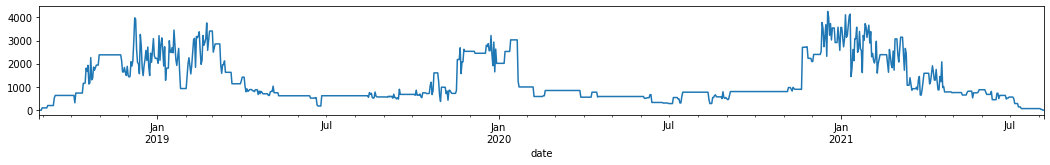

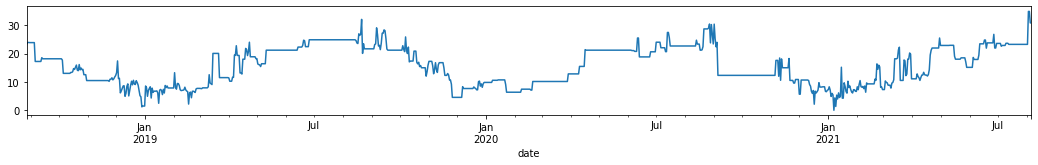

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018A2778A940>,
      dtype=object)

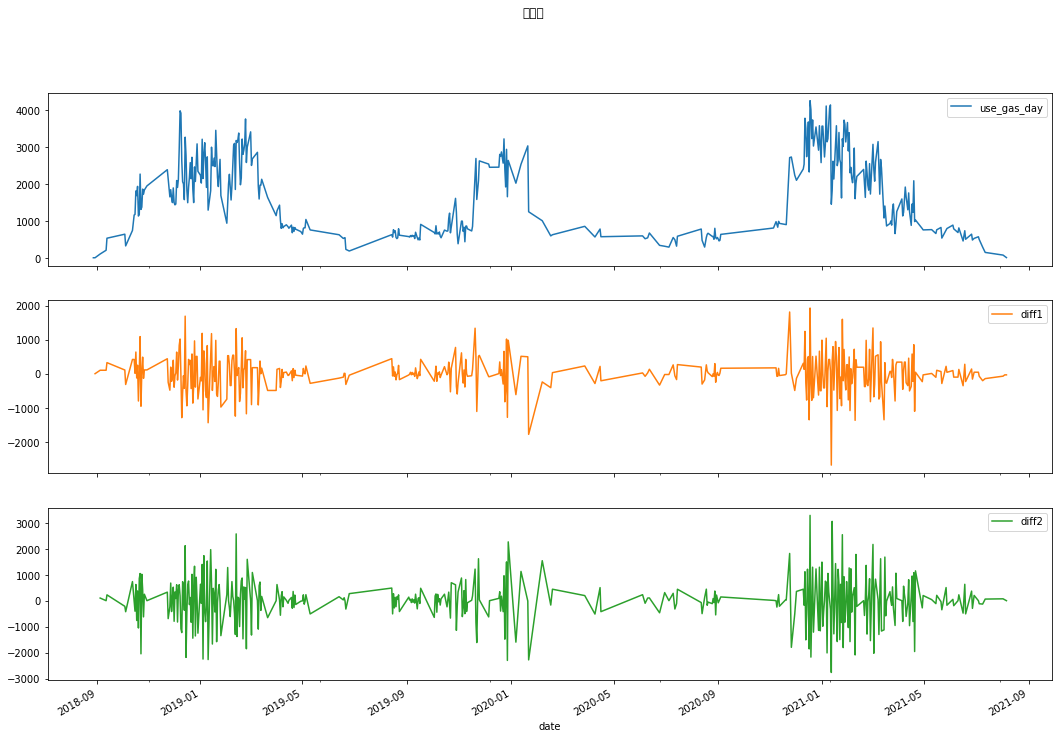

In [103]:
import numpy as np
import pandas as pd
import pymssql
import csv
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
#######################
file = pd.read_csv('C:/Users/admin/Desktop/csv/G_Data0000000683.csv')
sql_source = pd.DataFrame(file)
########################
sql_source.CreateDate = sql_source.CreateDate.astype('datetime64')
##############
target = pd.DataFrame(columns = ['date','T','use_gas_day'])
i = 0
j = 0
while i<len(sql_source)-1:
    while(i+1<len(sql_source) and sql_source.at[i,'CreateDate'].date()==sql_source.at[i+1,'CreateDate'].date()):
        i = i+1
    j = i+1
    while(j+1<len(sql_source) and sql_source.at[j,'CreateDate'].date()==sql_source.at[j+1,'CreateDate'].date()):
        j = j+1
    if(sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']<0):
        break
    if((sql_source.at[j,'CreateDate'].date()-sql_source.at[i,'CreateDate'].date()).days==1 and sql_source.at[i,'CreateDate'].hour==sql_source.at[j,'CreateDate'].hour and 10>=abs(sql_source.at[i,'CreateDate'].minute-sql_source.at[j,'CreateDate'].minute)>=0 and sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']>0):
        target = target.append([{'date':sql_source.at[j,'CreateDate'].date(),'T':sql_source.at[j,'T'],'use_gas_day':sql_source.at[j,'GTotal']-sql_source.at[i,'GTotal']}],ignore_index = True)
    i = j
    
##########################
i = 1
while i<len(target)-1:
    a = target.at[i-1,'use_gas_day']
    b = target.at[i,'use_gas_day']
    c = target.at[i+1,'use_gas_day']
    A = abs(b-a)/max(a,b)
    B = abs(c-b)/max(c,b)
    if(A>0.5 and B>0.5):
        target.at[i,'use_gas_day'] = (a+c)/2
    i = i+1
    
###########################
# Covnert date column to 时间戳Index
target = target.reset_index(drop=True).set_index('date')
target.index = pd.DatetimeIndex(target.index)
target = target.groupby('date')['T','use_gas_day'].sum().reset_index()
target = target.set_index('date')

#########################
import matplotlib.pyplot as plt
y = target['use_gas_day'].resample('D').mean()
#用下一个非缺失值填充该缺失值
y = y.fillna(y.bfill())

y_T = target['T'].resample('D').mean()
#用下一个非缺失值填充该缺失值
y_T = y_T.fillna(y_T.bfill())
###########################
y.plot(figsize=(18, 2))
plt.show()
y_T.plot(figsize=(18, 2))
plt.show()
#######################
target["diff1"] = target["use_gas_day"].diff(1).dropna()
target["diff2"] = target["diff1"].diff(1).dropna()
target01 = target.loc[:,["use_gas_day","diff1","diff2"]]
target01.plot(subplots=True, figsize=(18, 12),title="差分图")

In [102]:
# Define the p, d and q parameters to take any value between 0 and 2
import itertools
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
pdq = [(1,1,1)]
pdq = [(x[0], x[1], x[2]) for x in list(itertools.product(p, d, q))]

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[4]))

# Iterate a GridSearch function to test different parameters of seasonal ARIMA models 
import warnings 

warnings.filterwarnings("ignore") # specify to ignore warning messages
AIC_list = pd.DataFrame({}, columns=['param','param_seasonal','AIC'])
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            exog = y_T,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            temp = pd.DataFrame([[ param ,  param_seasonal , results.aic ]], columns=['param','param_seasonal','AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)  # DataFrame append
            del temp

        except:
            continue


m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
Min_AIC_list = AIC_list.iloc[l,:]

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)
SARIMAX: (0, 0, 0) x (0, 1, 1, 12)
SARIMAX: (0, 0, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:18406.09184865201
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:17553.53045530156
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:16566.95211593158
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:16278.77434713873
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:16564.397833214098
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:16454.867581826446
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:16309.350406304056
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:16208.411564337557
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:17334.376886785158
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:16684.409759031056
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:16084.752734943038
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:15723.365146320166
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:16079.544947279313
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:15894.083031809392
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:15795.1142371653

### Min_AIC_list ### 
param                 (1, 1, 1)
param_seasonal    (0, 1, 1, 12)
AIC                     15024.1
Name: 59, dtype: object
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3232      0.042      7.638      0.000       0.240       0.406
ma.L1         -0.6735      0.036    -18.648      0.000      -0.744      -0.603
ma.S.L12      -0.9769      0.012    -83.789      0.000      -1.000      -0.954
sigma2       9.67e+04   1812.888     53.342      0.000    9.32e+04       1e+05


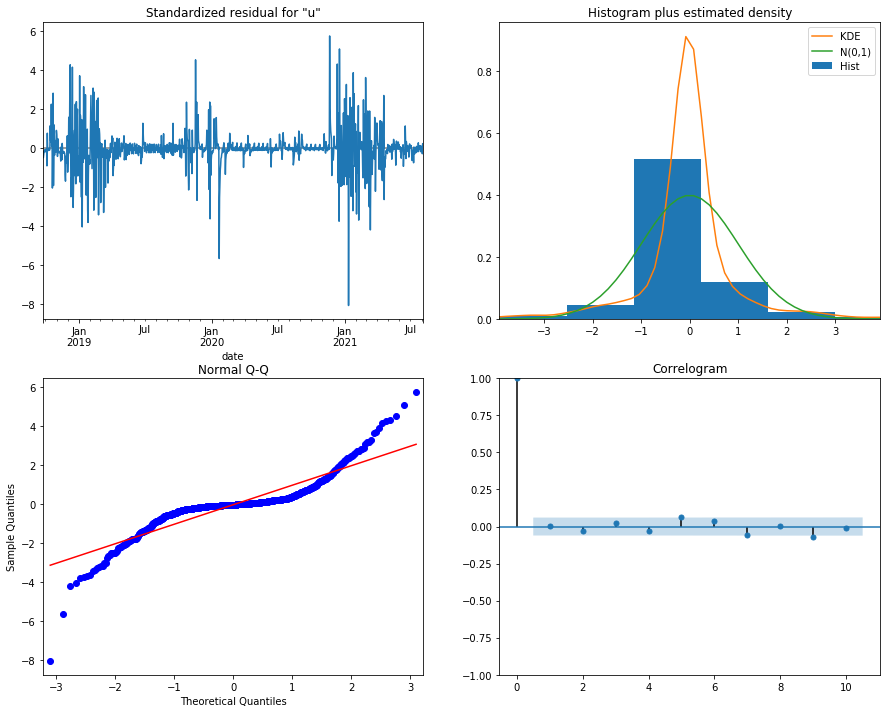

In [104]:
print("### Min_AIC_list ### \n{}".format(Min_AIC_list))
mod = sm.tsa.statespace.SARIMAX(y,
                                #exog = y_T,
                                order=Min_AIC_list.param,
                                seasonal_order=Min_AIC_list.param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

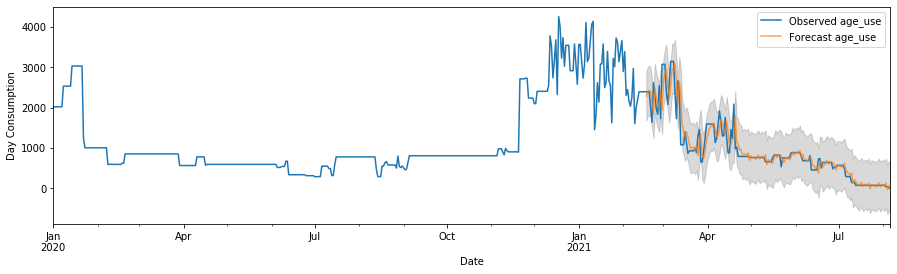

In [105]:
pred = results.get_prediction(start = pd.to_datetime('2021-2-17'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2020':].plot(label = 'Observed age_use')
pred.predicted_mean.plot(ax=ax, label='Forecast age_use', alpha=.7, figsize=(15, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha= 0.15)

ax.set_xlabel('Date')
ax.set_ylabel('Day Consumption')
plt.legend()

plt.show()

In [106]:
y_forecasted = pred.predicted_mean
y_forecasted_list = y_forecasted.to_list()
y_forecasted_arr = np.reshape(y_forecasted_list,(-1,1))
y_actual = y['2021-2-17':]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from numpy import *
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
test_mean = mean(y_actual)
mse = mean_squared_error(y_forecasted, y_actual)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt( mean_squared_error(y_forecasted, y_actual))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(y_actual,y_forecasted)

r2=r2_score(y_actual,y_forecasted)

acc = (test_mean-mae)/test_mean

print('test_mean: %.6f' % test_mean)
print('ARIMA模型的均方误差是: %.6f' % mse)
print('ARIMA模型的均方根误差是: %.6f' % rmse)
print('ARIMA模型的平均绝对误差是: %.6f' % mae)
print('ARIMA模型的R-squared是: %.6f' % r2)
print('ARIMA模型的acc是: %.6f' % acc)

test_mean: 959.823138
ARIMA模型的均方误差是: 78825.742060
ARIMA模型的均方根误差是: 280.759224
ARIMA模型的平均绝对误差是: 169.424869
ARIMA模型的R-squared是: 0.859679
ARIMA模型的acc是: 0.823483
